### Association Rule Mining

In [8]:
import pandas as pd
import numpy as np
import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
# Load dataset
df = pd.read_csv('Groceries_dataset.csv', header=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [9]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [10]:
#clearing column names
df.columns = df.columns.str.strip()
#altering date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.head()

C:\Users\lilai\AppData\Local\Temp\ipykernel_8756\2204074254.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


In [11]:
#Group Items by Transaction (Member + Date)
df_grouped = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index()
df_grouped.head()

,Member_number,Date,itemDescription
0,1000,2014-06-24,"[whole milk, pastry, salty snack]"
1,1000,2015-03-15,"[sausage, whole milk, semi-finished bread, yog..."
2,1000,2015-05-27,"[soda, pickled vegetables]"
3,1000,2015-07-24,"[canned beer, misc. beverages]"
4,1000,2015-11-25,"[sausage, hygiene articles]"


In [15]:
#one-hot encoding the dataset
te = TransactionEncoder()
te_ary = te.fit(df_grouped['itemDescription']).transform(df_grouped['itemDescription'])
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
df_encoded.shape

(14963, 167)

In [16]:
#chopping dataset to 6 with diifferent transactions
basket1 = df_encoded.head(500)
basket2 = df_encoded.head(1000)
basket3 = df_encoded.head(5000)
basket4 = df_encoded.head(10000)
basket5 = df_encoded.copy()


In [46]:
#Creating list of transactions
baskets = [basket1, basket2, basket3, basket4, basket5]
basket_sizes = ['500', '1000', '5000', '10000', 'Full']
results = []
#Running Apriori algorithm on different basket sizes
for i in range(len(baskets)):
    start_time = time.time()
    frequent_itemsets = apriori(baskets[i], min_support=0.005, use_colnames=True)
    end_time = time.time()
    duration = end_time - start_time
    results.append((basket_sizes[i], duration, len(frequent_itemsets)))
    print(f"Basket Size: {basket_sizes[i]}, Time Taken: {duration:.4f} seconds, Number of Frequent Itemsets: {len(frequent_itemsets)}")
#Displaying results
results_df = pd.DataFrame(results, columns=['Basket Size', 'Time Taken (s)', 'Number of Frequent Itemsets'])
print(results_df)

Basket Size: 500, Time Taken: 0.0120 seconds, Number of Frequent Itemsets: 172
Basket Size: 1000, Time Taken: 0.0198 seconds, Number of Frequent Itemsets: 173
Basket Size: 5000, Time Taken: 0.0569 seconds, Number of Frequent Itemsets: 131
Basket Size: 10000, Time Taken: 0.1873 seconds, Number of Frequent Itemsets: 131
Basket Size: Full, Time Taken: 0.1256 seconds, Number of Frequent Itemsets: 126
  Basket Size  Time Taken (s)  Number of Frequent Itemsets
0         500        0.011976                          172
1        1000        0.019798                          173
2        5000        0.056908                          131
3       10000        0.187252                          131
4        Full        0.125577                          126


In [47]:
#top 5 frequent itemsets from the full basket
frequent_itemsets = apriori(basket5, min_support=0.005, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head()
#printing association rules for full basket
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules.head())

          antecedents         consequents  antecedent support  \
0  (other vegetables)       (frankfurter)            0.122101   
1       (frankfurter)  (other vegetables)            0.037760   
2              (soda)           (sausage)            0.097106   
3           (sausage)              (soda)            0.060349   
4           (sausage)            (yogurt)            0.060349   

   consequent support   support  confidence      lift  representativity  \
0            0.037760  0.005146    0.042146  1.116150               1.0   
1            0.122101  0.005146    0.136283  1.116150               1.0   
2            0.060349  0.005948    0.061253  1.014975               1.0   
3            0.097106  0.005948    0.098560  1.014975               1.0   
4            0.085879  0.005748    0.095238  1.108986               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.000536    1.004579       0.118536  0.033261   0.004558    0.089214  
1  0.00053

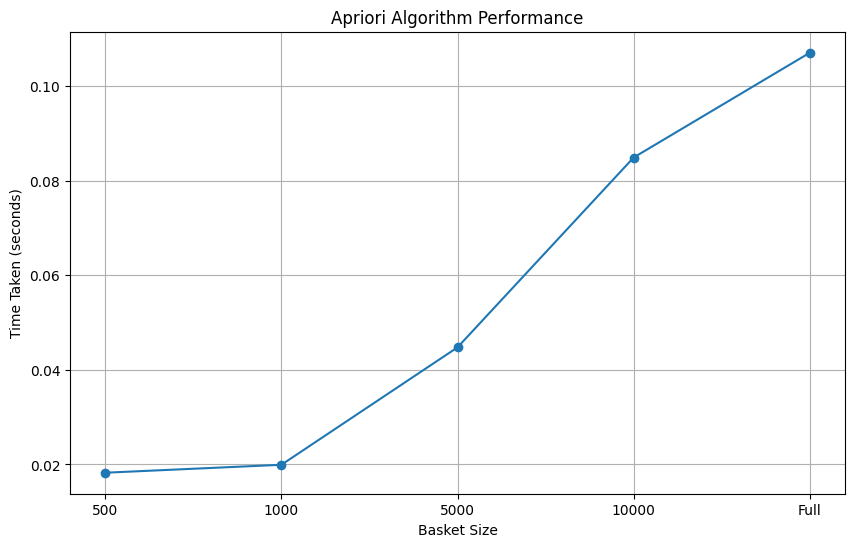

In [27]:
#graphing the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results_df['Basket Size'], results_df['Time Taken (s)'], marker='o')
plt.title('Apriori Algorithm Performance')
plt.xlabel('Basket Size')
plt.ylabel('Time Taken (seconds)')
plt.grid()
plt.show()

In [26]:
#estimating time taken for brutale force on different sizes
m = df_encoded.shape[0]  # number of transactions
n = df_encoded.shape[1]  # number of items
bruteforce_times = []
for size in basket_sizes:
    if size == '500':
        current_m = 500
    elif size == '1000':
        current_m = 1000
    elif size == '5000':
        current_m = 5000
    elif size == '10000':
        current_m = 10000
    else:
        current_m = m
    estimated_time = (2 ** n) * current_m * 1e-9  # assuming 1 nanosecond per operation
    bruteforce_times.append((size, estimated_time))
#Displaying brutale force estimation results
bruteforce_df = pd.DataFrame(bruteforce_times, columns=['Basket Size', 'Estimated Time Taken (s)'])
print(bruteforce_df)

  Basket Size  Estimated Time Taken (s)
0         500              9.353610e+43
1        1000              1.870722e+44
2        5000              9.353610e+44
3       10000              1.870722e+45
4        Full              2.799161e+45


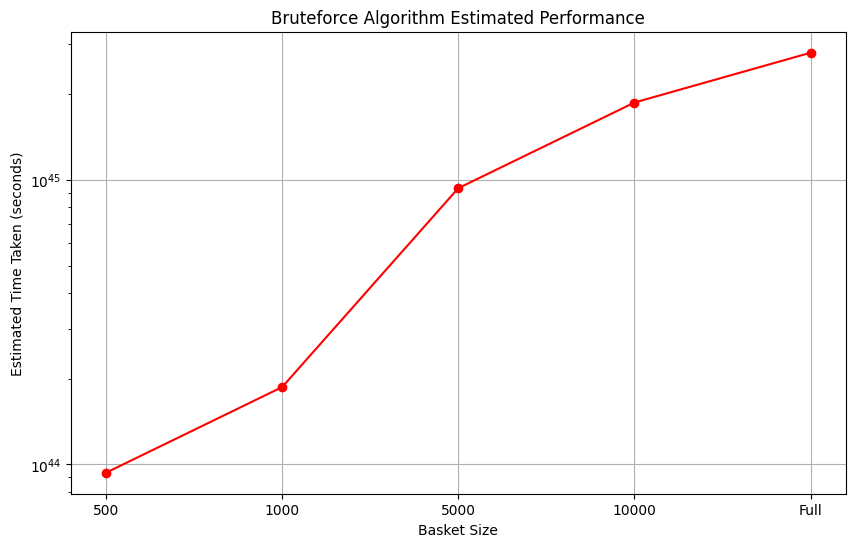

In [28]:
#graphing the results of brutale force estimation
plt.figure(figsize=(10, 6))
plt.plot(bruteforce_df['Basket Size'], bruteforce_df['Estimated Time Taken (s)'], marker='o', color='red')
plt.title('Bruteforce Algorithm Estimated Performance')
plt.xlabel('Basket Size')
plt.ylabel('Estimated Time Taken (seconds)')
plt.yscale('log')  # using logarithmic scale for better visualization
plt.grid()
plt.show()

  Basket Size  Time Taken (s)  Number of Frequent Itemsets  \
0         500        0.011976                          172   
1        1000        0.019798                          173   
2        5000        0.056908                          131   
3       10000        0.187252                          131   
4        Full        0.125577                          126   

   Estimated Time Taken (s)  
0              9.353610e+43  
1              1.870722e+44  
2              9.353610e+44  
3              1.870722e+45  
4              2.799161e+45  


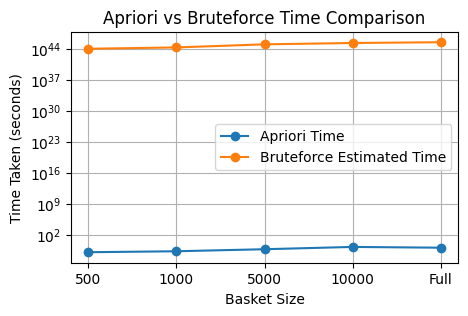

In [48]:
#comparing both results
comparison_df = results_df.merge(bruteforce_df, on='Basket Size')
print(comparison_df)
#graphing comparison
plt.figure(figsize=(5, 3))
plt.plot(comparison_df['Basket Size'], comparison_df['Time Taken (s)'], marker='o', label='Apriori Time')
plt.plot(comparison_df['Basket Size'], comparison_df['Estimated Time Taken (s)'], marker='o', label='Bruteforce Estimated Time')
plt.title('Apriori vs Bruteforce Time Comparison')
plt.xlabel('Basket Size')
plt.ylabel('Time Taken (seconds)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()